In [1]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import torch.nn.functional as F

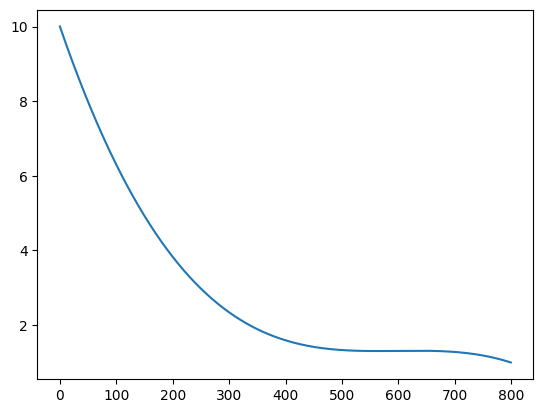

In [9]:
def depth_regression(X):
    return 1221.1025860930577 -6.13183029e+00*X + 1.03173169e-02*X**2 -5.76531414e-06*X**3

def depth_rescaling(X, old_range=[-32,1221], new_range=[1,10]):
    new_min, new_max = new_range
    old_min, old_max = old_range
    return (X - old_min) * (new_max - new_min) / (old_max - old_min) + new_min


# def depth_regression(y, img_height=800):
#     y = img_height - y
#     return np.exp( y*10 / (img_height) )

# print function on data from 0 to 800
x = np.arange(0, 800)
y = [depth_rescaling(depth_regression(i)) for i in x]
plt.plot(x, y)


In [7]:
max(y)

1221.1025860930577

In [18]:
def loss_depth_scaled_dist(out_point, tgt_point, num_boxes=1):
    loss = F.l1_loss(out_point, tgt_point, reduction='none')
    depth = torch.tensor([depth_regression(yi) for yi in tgt_point[:,1]])
    loss = loss * depth[:, None]  # None adds a new axis to scalars
    return loss.sum() / num_boxes

In [19]:
out_point = torch.tensor([
    [0,500],
    [10,200],
    ]).float()

tgt_point = torch.tensor([
    [1,500],
    [10,300],
    ]).float()

loss_depth_scaled_dist(out_point, tgt_point)

tensor([ 13.8526, 154.4485])


tensor([[1.3853e+01, 0.0000e+00],
        [0.0000e+00, 1.5445e+04]])

In [1]:
def iou(boxA, boxB):
    """ Compute bbox IoU. """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

100%|██████████| 100000/100000 [00:00<00:00, 132558.85it/s]


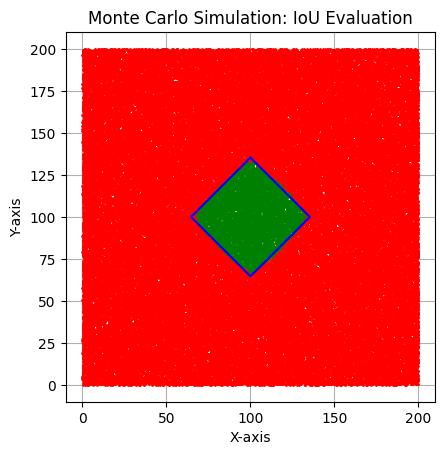

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set the size and center of the reference bounding box
size = 100
ref_box_size = (size, size)
ref_box_center = (size, size)

# Define the number of random boxes to generate
n = 100000

# Set the IoU threshold for acceptance
iou_threshold = 0.5

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the reference bounding box
ref_box = plt.Rectangle(
    (ref_box_center[0] - ref_box_size[0] / 2, ref_box_center[1] - ref_box_size[1] / 2),
    ref_box_size[0],
    ref_box_size[1],
    edgecolor='blue',
    facecolor='none',
)


# Initialize lists to store the centers and colors of generated boxes
centers = []
colors = []

# Generate random boxes and check their IoU with the reference box
for _ in tqdm(range(n)):
    box_center = (np.random.uniform(0, 2*size), np.random.uniform(0, 2*size))

    # Calculate the IoU with the reference box
    xA = max(ref_box_center[0] - ref_box_size[0] / 2, box_center[0] - ref_box_size[0] / 2)
    yA = max(ref_box_center[1] - ref_box_size[1] / 2, box_center[1] - ref_box_size[1] / 2)
    xB = min(ref_box_center[0] + ref_box_size[0] / 2, box_center[0] + ref_box_size[0] / 2)
    yB = min(ref_box_center[1] + ref_box_size[1] / 2, box_center[1] + ref_box_size[1] / 2)

    intersection_area = max(0, xB - xA) * max(0, yB - yA)
    union_area = ref_box_size[0] * ref_box_size[1] + ref_box_size[0] * ref_box_size[1] - intersection_area
    iou = intersection_area / union_area

    # Determine the color based on IoU
    if iou > iou_threshold:
        color = 'green'
    else:
        color = 'red'

    # Append the center and color to the lists
    centers.append(box_center)
    colors.append(color)

# Plot the generated boxes as dots
for center, color in zip(centers, colors):
    ax.plot(center[0], center[1], 'o', markersize=1, color=color)

shift = size / 4 * np.sqrt(2)
top = (size, size + shift)
left = (size - shift, size)
bottom = (size, size - shift)
right = (size + shift, size)

# Plot a diamond
ax.plot([top[0], left[0], bottom[0], right[0], top[0]], [top[1], left[1], bottom[1], right[1], top[1]], color='blue')
ax.add_patch(ref_box)
# Set axis limits
# ax.set_xlim(0, size)
# ax.set_ylim(0, size)

# Add labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
plt.title('Monte Carlo Simulation: IoU Evaluation')

# keep aspect ratio
ax.set_aspect('equal', adjustable='box')

# Show the plot
plt.grid()
plt.show()


